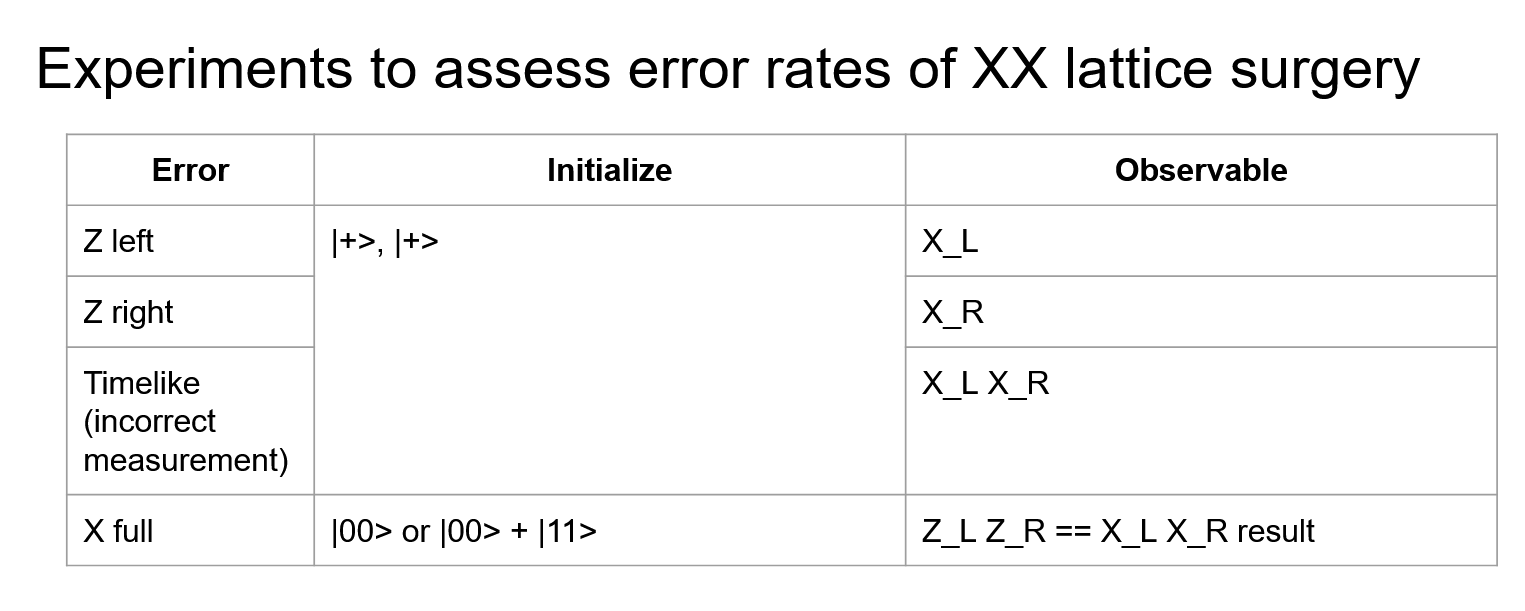

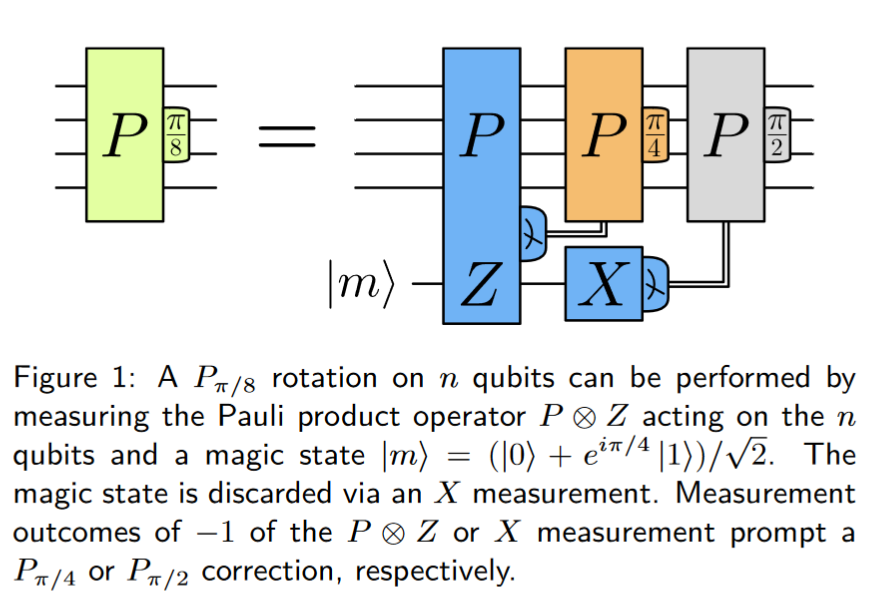

Recall that the notation $P_\theta = \exp (- i \theta P)$ so that $P_{\pi / 8} = T, P_{\pi / 4} = S, P_{\pi / 2} = Z$. 

There are four error mechanisms at play for our ZZ lattice surgery on qubits $0, 1$:
1. $X_0$ $(p_0)$ ($00 \mapsto 10$).
2. $X_1$ $(p_1)$ ($00 \mapsto 01$). 
3. Timelike $(p_{TL})$ (incorrectly perform $P_{\pi / 4}$ gate). 
4. $Z$ full $(p_F)$ $00 + 11 \mapsto 00 - 11$. 
Call $\ket{\psi}$ to be $0$ and $\ket{T}$ to be $1$. Then,

The error mechanisms act in the following ways:
1. $X_0$ is a logical $X$ error, which damages all previous / future gates, this should be avoided.
2. $X_1$ is a logical $X$ error on the ancilla, which doesn't matter as this additional $X$ gate will commute with the measurement.
3. We will accidently perform an additional (or missing) $P_{\pi / 4}$ gate. This is an additional $S$ gate. This counts as a half error if it occurs on the top qubit via projector logic.
4. The $Z$ error can be thought to act only on the $\ket{m}$ state, as the entire state is stabilized by $ZZ$. We perform an additional $P_{\pi / 2}$ gate, a full $Z$ error.





So that:
$$
E = p_0 + 0 \cdot p_1 + \frac{1}{2} p_{TL} + p_F
$$

Projector logic.

Suppose that, as we had seen earlier, had a $Z$ fault in our magic state. In the ZZ measurement phase, this has no impact on our entangled state, but it does affect the $X$ measurement and thus erroneously applies some $Z...Z$ string.

At the end of computation, we ideally would have some $\ket{\psi}$ which reads out all $+1$s on the $X$ measurements, i.e. $\Pi_{i} \ket{\psi} = \ket{\psi}$. However, our erroneous $Z$ string can be thought of as the following:
$$
Z_0 Z_i \ket{\psi} =  Z_0 Z_i \Pi_i \ket{\psi} = Z_0 Z_i \frac{I + X_i}{2} \ket{\psi} = \frac{I - X_i}{2} Z_0 Z_i \ket{\psi}
$$
So that we now measure a $-1$ on that qubit, alongside effecting a $Z$ error on the output qubit. 

To consider the $S$ case, note that $P_{\pi / 4} = \cos \frac{\pi}{4} I - i \sin \frac{\pi}{4} Z...Z$ for some $Z$ string. To simplify, we may write this as $\frac{I - i Z}{\sqrt{2}}$. Then:
$$
\frac{I - i Z_0 Z_k}{\sqrt{2}} \frac{I + X_k}{2} = \frac{I + X_k}{2} \frac{I}{\sqrt{2}} + \frac{I - X_k}{2} \frac{-i Z_0 Z_k}{\sqrt{2}}
$$
I.e. there is a 50\% chance of measuring a $1$, in which case we project a $Z$ error onto the output qubit. 